# AirBnb in Brussels

## The dataset

The dataset is obtained from "[inside AirBnb](https://insideairbnb.com/get-the-data/)" and distributed under the [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

## Introduction

This markdown document is a summary of the results of the data analysis.
The code is reported in the following cells.

## Types of accommodations

To start, we check how many kinds of accommodations are available in the database. The accommodations can be:
* Entire home
* Private room
* Hotel room
* Shared room

<img src="pie_accommodation.png" width="500" />

We plot the count of accommodation type per neighbourhood. Note that the histogram on the right is normalized to improve clarity. 
<p float="left">
  <img src="neighborhoods_accommodation.png" width="500" /> 
  <img src="neighborhoods_accommodation_normalized.png" width="500" />
</p>

The distribution of accommodation types seems relatively uniform among neighbourhood.

**We observe that hotel rooms and shared rooms are rare in the dataset, consequently we exclude them from the following analysis.**

## Checking the reviews

The dataset contains six kinds of scores:
* Overall score
* Accuracy of the description
* Cleanliness
* Check-in experience
* Communication experience
* Location

We plot the correlation matrix of these scores.

![Correlation Scores](correlation_scores.png)

We draw three observations.

First, the *location* score has a low correlation with all the other scores. We explain this by noticing that the quality of the location (intended as the neighborhood) is not directly under the control of the host. For example, a host can offer an excellent experience in terms of accuracy, cleanliness, check-in, and communication, but cannot do much to improve the quality of their neighborhood. **Interestingly, we observe that the location does not correlate much with the overall score, indicating that the users, on average, do not penalize much a host by lowering the overall score when the location is not satisfactory.**

Second, the *cleanliness* does not correlate well with *check-in* and *communication*. We explain this by noticing that, most commonly, the entity providing the cleaning service is different from the one providing the check-in and communication. Consequently, it is reasonable to observe that their scores do not correlate well.

Finally, we observe how the *overall* score correlates with the others. We see that *accuracy* is the most correlated one, followed by *cleanliness*, *check-in experience*, *communication* and, at last, *location*. **This can be interpreted as a list of what is more important to the user.** According to this list, an inaccurate description can affect more the overall score than bad communication.

### Location score and price per neighborhood

Continuing the analysis started in the previous section, we visualize the location scores by neighborhood. Dots indicate the mean value and error bars indicate the standard deviation.

<img src="neighborhoods_scores.png"/> 

**This seems to be well correlated with the real estate value per neighborhood.** This finding is easy to explain: the real estate value is a good predictor of the attractiveness of a neighborhood, and consequently, it correlates well with the rating that the users give to a specific location.

<img src="real_estate_prices.png" width="500"/>

The same trend is found in the prices. To facilitate comparisons, we only considered accommodations for 2 persons.

<img src="neighborhoods_prices.png"/>

### More on the communication score

We observe that the score assigned to the communication experience is inversely correlated with the numbers of listings of the same host. In other words, **an host having multiple rooms for rent is more likely to have a lower communication score.** The correlation coefficient on the full database is -0.10. The correlation coefficient considering only hosts with less than 15 rooms for rent is -0.14. 


<p float="left">
  <img src="commscore_vs_listings.png" width="400" />
  <img src="checkinscore_vs_listings.png" width="400" />
</p>



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pingouin as pg

from collections import defaultdict

filename = "listings.csv"
cols=["host_id","host_since","host_response_time","host_response_rate",
      "host_acceptance_rate","host_is_superhost","host_neighbourhood",
      "host_listings_count","host_total_listings_count","host_has_profile_pic",
      "host_identity_verified","neighbourhood_cleansed","latitude",
      "longitude","property_type","room_type",
      "accommodates",
      "beds","price",
      "number_of_reviews","review_scores_rating","review_scores_accuracy",
      "review_scores_cleanliness","review_scores_checkin","review_scores_communication",
      "review_scores_location","review_scores_value","instant_bookable",
      "calculated_host_listings_count","calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms",
      "calculated_host_listings_count_shared_rooms","reviews_per_month"]
data = pd.read_csv(filename, usecols=cols)

# Convert the prices from string to floats
data['price'] = data['price'].str.replace('\$', '', regex=True).str.replace(',', '').astype(float)

# Drop some entries that are clearly broken (normal appartments with price > 1500€ per night)
to_drop = [396, 1530, 1531]
data.drop(to_drop, inplace=True)

# Prepare a color palette, useful later
palette = []
for color in mcolors.TABLEAU_COLORS.values():
      palette.append(color)

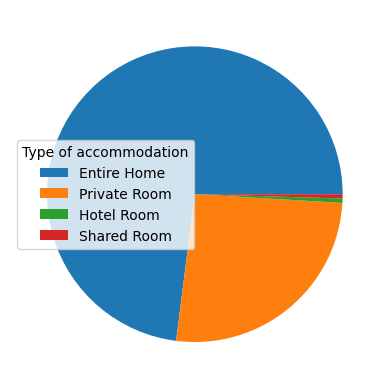

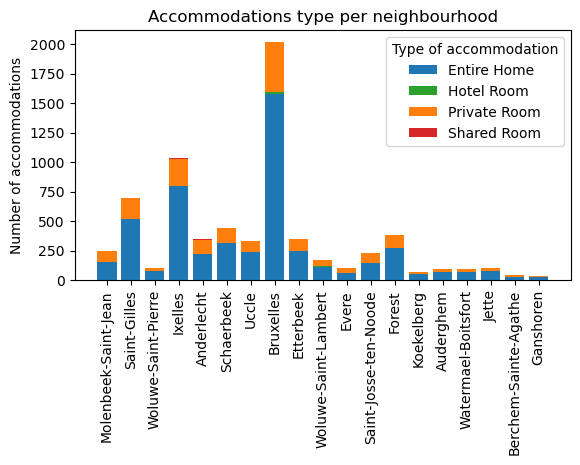

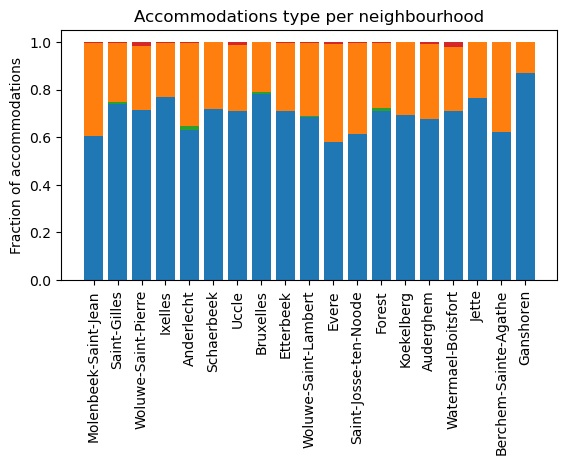

In [3]:
# Evaluate the kinds of accomodations in the dataset

ax = data['room_type'].value_counts().plot.pie(labels=None)
ax.legend(["Entire Home", "Private Room", "Hotel Room", "Shared Room"], title="Type of accommodation")
ax.set_ylabel("")
plt.savefig('pie_accommodation.png')
plt.show()

# Evaluate type of room per neighbourhood

room_type_per_neighbourhood = dict()
total_room_per_neighbourhood = dict()
for entry in data["neighbourhood_cleansed"].unique():
    room_type_per_neighbourhood[entry]=data[data['neighbourhood_cleansed']==entry]['room_type'].value_counts()
    total_room_per_neighbourhood[entry]=data[data['neighbourhood_cleansed']==entry]['room_type'].value_counts().sum()

i = 0
colors = dict()
for room_type in ['Entire home/apt',  'Private room', 'Hotel room', 'Shared room']: # Same order of the pie plot
    colors[room_type] = palette[i]
    i+=1

for neighbourhood in data["neighbourhood_cleansed"].unique():
    bottom = 0
    for room_type in data['room_type'].unique():
        if room_type in room_type_per_neighbourhood[neighbourhood]:
            plt.bar(neighbourhood, room_type_per_neighbourhood[neighbourhood][room_type], bottom=bottom, color=colors[room_type])
            bottom+=room_type_per_neighbourhood[neighbourhood][room_type]
        else:
            plt.bar(neighbourhood, 0, color=colors[room_type])
plt.legend(["Entire Home", "Hotel Room","Private Room",  "Shared Room"], title="Type of accommodation")
plt.xticks(range(len(data["neighbourhood_cleansed"].unique())), data["neighbourhood_cleansed"].unique(), rotation=90)
plt.ylabel("Number of accommodations")
plt.gcf().set_figheight(5)
plt.gcf().subplots_adjust(bottom=0.38)
plt.title("Accommodations type per neighbourhood")
plt.savefig('neighborhoods_accommodation.png')
plt.show()

# Do the same plot but now normalized

for neighbourhood in data["neighbourhood_cleansed"].unique():
    bottom = 0
    for room_type in data['room_type'].unique():
        if room_type in room_type_per_neighbourhood[neighbourhood]:
            plt.bar(neighbourhood, room_type_per_neighbourhood[neighbourhood][room_type]/total_room_per_neighbourhood[neighbourhood], bottom=bottom, color=colors[room_type])
            bottom+=room_type_per_neighbourhood[neighbourhood][room_type]/total_room_per_neighbourhood[neighbourhood]
        else:
            plt.bar(neighbourhood, 0, color=colors[room_type])
#plt.legend(["Entire Home", "Hotel Room","Private Room",  "Shared Room"], title="Type of accommodation")
plt.xticks(range(len(data["neighbourhood_cleansed"].unique())), data["neighbourhood_cleansed"].unique(), rotation=90)
plt.ylabel("Fraction of accommodations")
plt.gcf().set_figheight(5)
plt.gcf().subplots_adjust(bottom=0.38)
plt.title("Accommodations type per neighbourhood")
plt.savefig('neighborhoods_accommodation_normalized.png')
plt.show()

In [4]:
# Drop hotel rooms and shared rooms because they are not common in the dataset and could produce misleading results
data = data[data['room_type']!='Hotel room']
data = data[data['room_type']!='Shared room']


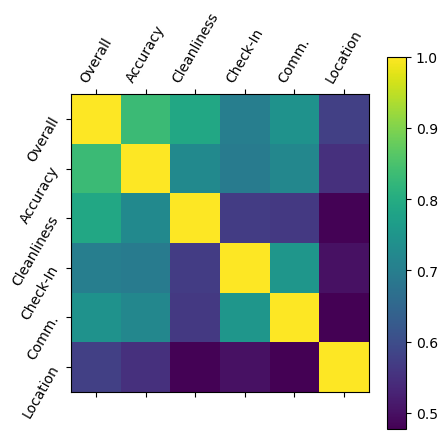

In [5]:
# Evaluate the correlation among different kinds of score

columns = ["review_scores_rating","review_scores_accuracy", "review_scores_cleanliness",
           "review_scores_checkin","review_scores_communication", "review_scores_location"]
labels  = ["Overall", "Accuracy", "Cleanliness","Check-In", "Comm.", "Location"]
plt.matshow(data[columns].corr())
plt.xticks(range(6), labels, rotation=60)
plt.yticks(range(6), labels, rotation=60)
plt.ylim(5.5, -0.5)
plt.colorbar()
plt.savefig('correlation_scores.png')

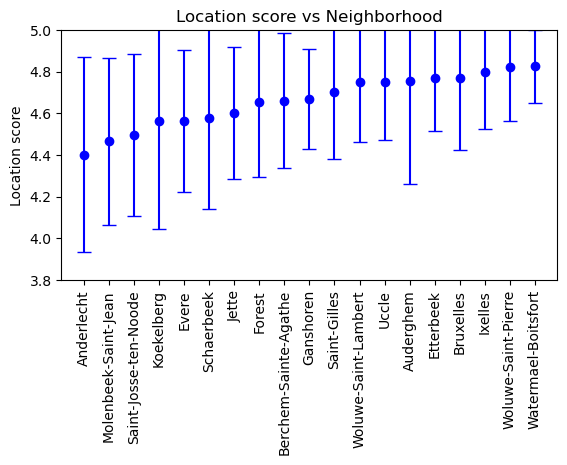

In [6]:
# Extract the location score for each neighborhood

neighborhoods = data["neighbourhood_cleansed"].unique()

mean_total = data.groupby('neighbourhood_cleansed')['review_scores_location'].mean()
std_total  = data.groupby('neighbourhood_cleansed')['review_scores_location'].std()
mean_per_neighborhood = [mean_total[entry] for entry in neighborhoods]
std_per_neighborhood  = [std_total[entry] for entry in neighborhoods]

# Sort by mean score
sorted_indexes = [i for i, _ in sorted(enumerate(mean_per_neighborhood), key=lambda x:x[1])]
neighborhoods = [neighborhoods[idx] for idx in sorted_indexes]
mean_per_neighborhood = [mean_per_neighborhood[idx] for idx in sorted_indexes]
std_per_neighborhood  = [std_per_neighborhood[idx] for idx in sorted_indexes]

for i in range(len(neighborhoods)):
    plt.errorbar(i, mean_per_neighborhood[i], yerr=std_per_neighborhood[i], fmt='o', color='blue', ecolor='blue', capsize=5)
plt.ylim(3.8, 5)
plt.xticks(range(len(neighborhoods)), neighborhoods, rotation=90)
plt.ylabel("Location score")
plt.gcf().set_figheight(5)
plt.gcf().subplots_adjust(bottom=0.38)
plt.title("Location score vs Neighborhood")
plt.savefig('neighborhoods_scores.png')

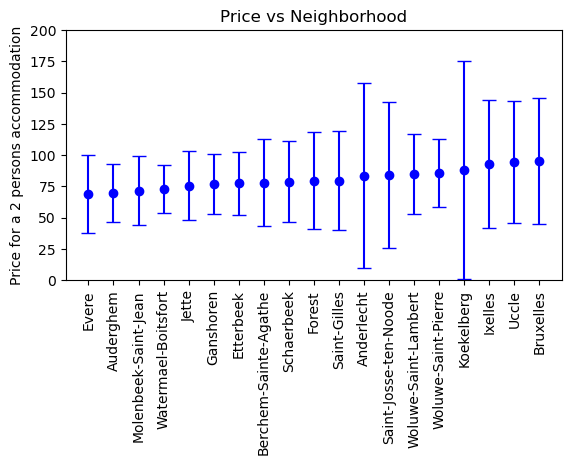

In [7]:
# Extract the price for each neighborhood

neighborhoods = data["neighbourhood_cleansed"].unique()

mean_total = data[data['accommodates']==2].groupby('neighbourhood_cleansed')['price'].mean()
std_total  = data[data['accommodates']==2].groupby('neighbourhood_cleansed')['price'].std()
mean_per_neighborhood = [mean_total[entry] for entry in neighborhoods]
std_per_neighborhood  = [std_total[entry] for entry in neighborhoods]

# Sort by mean score
sorted_indexes = [i for i, _ in sorted(enumerate(mean_per_neighborhood), key=lambda x:x[1])]
neighborhoods = [neighborhoods[idx] for idx in sorted_indexes]
mean_per_neighborhood = [mean_per_neighborhood[idx] for idx in sorted_indexes]
std_per_neighborhood  = [std_per_neighborhood[idx] for idx in sorted_indexes]

for i in range(len(neighborhoods)):
    plt.errorbar(i, mean_per_neighborhood[i], yerr=std_per_neighborhood[i], fmt='o', color='blue', ecolor='blue', capsize=5)
plt.ylim(0, 200)
plt.xticks(range(len(neighborhoods)), neighborhoods, rotation=90)
plt.ylabel("Price for a 2 persons accommodation")
plt.gcf().set_figheight(5)
plt.gcf().subplots_adjust(bottom=0.38)
plt.title("Price vs Neighborhood")
plt.savefig('neighborhoods_prices.png')


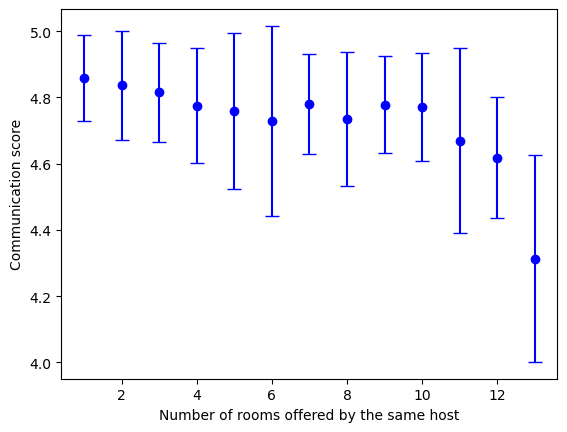

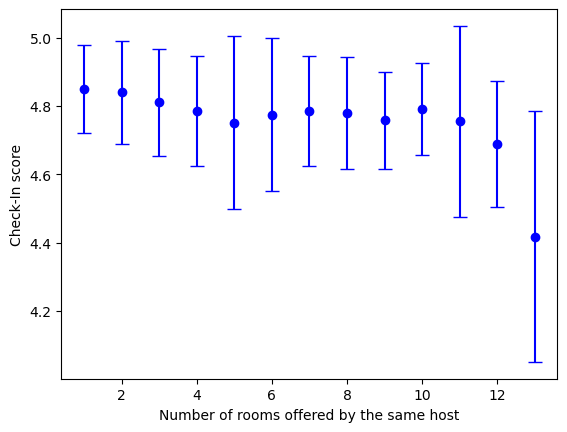

In [8]:
# Extract the correlation between listing count and scores

for count in range(1, 14):
    plt.errorbar(x=count, y=data[data['host_total_listings_count']==count]['review_scores_communication'].mean(),yerr= data[data['host_total_listings_count']==count]['review_scores_communication'].std()/2, fmt='o', color='blue', capsize=5)
plt.xlabel("Number of rooms offered by the same host")
plt.ylabel("Communication score")
plt.savefig('commscore_vs_listings.png')
plt.show()

plt.figure()
for count in range(1, 14):
    plt.errorbar(x=count, y=data[data['host_total_listings_count']==count]['review_scores_checkin'].mean(),yerr= data[data['host_total_listings_count']==count]['review_scores_checkin'].std()/2, fmt='o', color='blue', capsize=5)
plt.xlabel("Number of rooms offered by the same host")
plt.ylabel("Check-In score")
plt.savefig('checkinscore_vs_listings.png')
plt.show()

In [24]:
# Work in progress
data[data['host_total_listings_count']<15][['host_total_listings_count', 'review_scores_cleanliness', 'review_scores_checkin']].corr()
for i in ['review_scores_checkin', 'review_scores_communication', 'review_scores_accuracy', 'review_scores_location', 'review_scores_cleanliness', 'review_scores_rating', 'review_scores_value', 'price']:
    print(i)
    print(pg.corr(data[data['host_total_listings_count']<11]['host_total_listings_count'], data[data['host_total_listings_count']<11][i],     method='pearson'))
    print('***')

review_scores_checkin
            n         r           CI95%         p-val      BF10     power
pearson  4758 -0.087307  [-0.12, -0.06]  1.617000e-09  1.44e+06  0.999977
***
review_scores_communication
            n         r           CI95%         p-val       BF10  power
pearson  4758 -0.109121  [-0.14, -0.08]  4.436249e-14  4.219e+10    1.0
***
review_scores_accuracy
            n         r          CI95%         p-val       BF10  power
pearson  4758 -0.127508  [-0.16, -0.1]  1.055968e-18  1.517e+15    1.0
***
review_scores_location
            n         r           CI95%     p-val    BF10     power
pearson  4758 -0.059799  [-0.09, -0.03]  0.000037  90.672  0.984956
***
review_scores_cleanliness
            n         r           CI95%     p-val    BF10     power
pearson  4758 -0.054973  [-0.08, -0.03]  0.000148  24.199  0.966748
***
review_scores_rating
            n         r          CI95%         p-val       BF10  power
pearson  4759 -0.128698  [-0.16, -0.1]  4.964093e-19  3.196e